In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import csv
from sklearn.model_selection import train_test_split
import json
import copy
import math

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision.transforms import ToTensor
import torchvision.transforms as transforms
import torchvision.transforms.functional as fn

import matplotlib.patches as patches
import albumentations as A
import cv2
import os
from pycocotools import cocoeval, coco
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
import sys, os

from tqdm import tqdm
from torch.optim.lr_scheduler import CosineAnnealingLR, CosineAnnealingWarmRestarts
from warmup_scheduler import GradualWarmupScheduler
import matplotlib.ticker as ticker
import random

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## Augmentation

In [3]:
Img_size_training = 256
preprocess = A.Compose([
    A.RandomCrop(width=Img_size_training, height=Img_size_training),
], 
bbox_params=A.BboxParams(
    format='pascal_voc', 
    min_area=2000, 
    min_visibility=0.1, 
    label_fields=['category_ids']
    )
)

augumentation = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.GaussNoise(p=0.5),
    A.Cutout(p=0.5, num_holes=100, max_h_size=3, max_w_size=3, fill_value=255),
    A.RandomShadow(p=0.5),
],bbox_params=A.BboxParams(
    format='pascal_voc', 
    min_area=500, 
    min_visibility=0.1, 
    label_fields=['category_ids']
    )
)

/home/user/micromamba/lib/python3.9/site-packages/albumentations/augmentations/dropout/cutout.py:49: FutureWarning: Cutout has been deprecated. Please use CoarseDropout
  warnings.warn(


## visualization function

In [4]:
BOX_COLOR = (255, 0, 0) # Red
TEXT_COLOR = (255, 255, 255) # White
category_id_to_name = {1: 'mitotic', 2: 'not mitotic'}

def visualize_bbox(img, bbox, class_name, color=BOX_COLOR,textcolor=TEXT_COLOR, thickness=2):
    """Visualizes a single bounding box on the image"""
    x_min, y_min, x_max, y_max = bbox
    x_min, y_min, x_max, y_max = int(x_min), int(y_min), int(x_max), int(y_max)
   
    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=color, thickness=thickness)
    
    ((text_width, text_height), _) = cv2.getTextSize(class_name, cv2.FONT_HERSHEY_COMPLEX_SMALL, 0.5, 1)    
    cv2.rectangle(img, (x_min, y_min - int(1.3 * text_height)), (x_min + text_width, y_min), color, -1)
    cv2.putText(
        img,
        text=class_name,
        org=(x_min, y_min - int(0.3 * text_height)),
        fontFace=cv2.FONT_HERSHEY_COMPLEX_SMALL,
        fontScale=0.5, 
        color=textcolor, 
        lineType=cv2.LINE_AA,
    )
    return img


def visualize(image, bboxes, category_ids, category_id_to_name):
    img = image.copy()
    for bbox, category_id in zip(bboxes, category_ids):
        class_name = category_id_to_name[category_id]
        img = visualize_bbox(img, bbox, class_name)
    plt.figure(figsize=(6, 6))
    plt.axis('off')
    plt.imshow(img)

## Data Collection
將官方標注資料轉換成新的標注集gt_labels.json，此後就可以直接使用

In [5]:
def bboxhasErr(box):
    if int(box[0])<0 or int(box[1])<0 or int(box[2])>img_width or int(box[3])>img_height or int(box[0])>=int(box[2]) or int(box[1])>=int(box[3]):
        return True
    else: 
        return False
     

In [6]:
trainset = []
category_id_to_name = {1: 'mitotic', 2: 'not mitotic'}
f = open('MICCAI_v2/cutted_labels/train_gt_labels.json')
data = json.load(f)
labels={}
pre_imgID = 1
img_hasMitoticCell = False

for a in data['annotations']:
    cur_imgID = img_id =  int(a['image_id'])
    if cur_imgID != pre_imgID :
        trainset.append([img_name, img_path,
                        labels[img_id-1]['boxes'],
                        labels[img_id-1]['class_name'],
                        labels[img_id-1]['class_id']])
        pre_imgID = cur_imgID
    img_name = '{:0>4}.png'.format(img_id)
    class_id = int(a['category_id'])
    img_width = data['images'][img_id-1]['width']
    img_height = data['images'][img_id-1]['height']
    class_label = category_id_to_name[class_id]
    img_path = os.path.join('MICCAI_v2/cutted_images/train/{:0>4}.png'.format(img_id))
    box = a['bbox']
    #in case annotation box out of range
    if bboxhasErr(box):
        continue
    else:
        box_info = [int(box[0]), int(box[1]), int(box[2]), int(box[3])]
        if img_id not in labels.keys():
            labels[img_id] = {}
            labels[img_id]['boxes']=[]
            labels[img_id]['class_name']=[]
            labels[img_id]['class_id']=[]
        labels[img_id]['boxes'].append(box_info)
        labels[img_id]['class_name'].append(class_label)
        labels[img_id]['class_id'].append(class_id)

trainset[1]

['0002.png',
 'MICCAI_v2/cutted_images/train/0002.png',
 [[156, 157, 206, 206]],
 ['mitotic'],
 [1]]

In [7]:
test_dataset = []
valid_dataset = []
f = open('MICCAI_v2/cutted_labels/test_gt_labels.json')
data = json.load(f)

for a in data['images']:
    img_id = a['id']
    boxes=[]
    labels=[]
    class_labels=[]
    for annot in data['annotations']:
        if annot['image_id']==img_id:
            boxes.append(annot['bbox'])
            labels.append(annot['category_id'])
            class_labels.append(category_id_to_name[annot['category_id']])
    img_path = os.path.join('MICCAI_v2/cutted_images/test&valid/{:0>4}.png'.format(img_id))
    if len(boxes)>0:
        valid_dataset .append([
            '{:0>4}.png'.format(img_id),
            img_path,
            boxes,
            class_labels,
            labels
        ])
    else:
        test_dataset.append([
            '{:0>4}.png'.format(img_id),
            img_path,
            boxes,
            class_labels,
            labels
        ])

In [8]:
test_dataset[0]
print(len(test_dataset))

1773


In [9]:
valid_dataset[0]
print(len(valid_dataset))

1227


In [10]:
test_dataset[0]

['0001.png', 'MICCAI_v2/cutted_images/test&valid/0001.png', [], [], []]

## Augmentation test

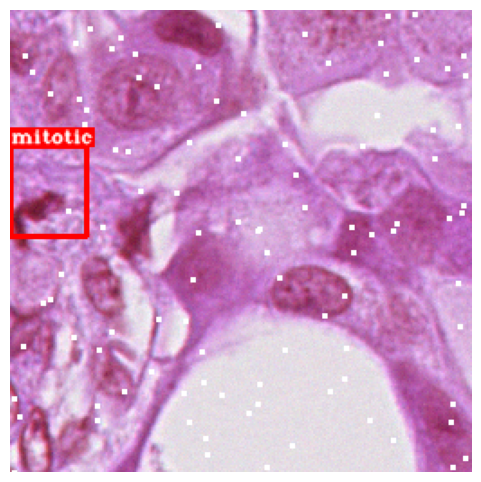

In [12]:
test_imgID = 1
image = cv2.imread('MICCAI_v2/cutted_images/train/{:0>4}.png'.format(test_imgID))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


transformed = augumentation(
    image=image, 
    bboxes=trainset[test_imgID-1][2], 
    category_ids=trainset[test_imgID-1][4],
)

img = transformed['image']
boxes = transformed['bboxes']
labels = transformed['category_ids']

visualize(img, boxes, labels, category_id_to_name)


## Cut Image and Save

## Define DataSet class

In [11]:
class Dataset(Dataset):
    def __init__(self, data,transform=None, istrained=True, isvalided=False):
        self.images_path = []
        self.img_ids = []
        self.boxes = []
        self.class_id = []
        self.transform = transform
        self.istrained = istrained
        self.isvalided = isvalided
        self.meanList = []
        self.stdList = []
        for i in data:
            self.img_ids.append(i[0])
            self.images_path.append(i[1])
            self.boxes.append(i[2])
            self.class_id.append(i[4])


    
    def __len__(self):
        return len(self.images_path)
    
    def __getitem__(self, idx):
        # print(self.images_path[idx])
        boxes = self.boxes[idx]
        labels = self.class_id[idx]
        img = cv2.imread(self.images_path[idx])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


        img = np.array(img, dtype=np.uint8)

        if self.istrained==True and self.isvalided==False:
            transformed = augumentation(
                image=img, 
                bboxes=boxes, 
                category_ids=labels,
            )

            img = transformed['image']
            boxes = transformed['bboxes']
            labels = transformed['category_ids']
        
        
        target = {}
        # if self.istrained==True:
        boxes = np.array(boxes)
        labels = np.array(labels)
        boxes = torch.from_numpy(boxes).to(torch.float32)
        # boxes = boxes.squeeze(0)
        labels = torch.from_numpy(labels).to(torch.int64)
        # labels = labels.squeeze(0)
 

        target['boxes'] = boxes
        target['labels'] = labels
        
        
       
        img= self.transform(img)
        mean, std = img.mean([1,2]), img.std([1,2])
        img = fn.normalize(img, mean=mean, std=std)
        
        if self.istrained==False:
            target['img_id'] = self.img_ids[idx]
            target['mean'] = mean
            target['std'] = std
            target['path'] = self.images_path[idx]

        return img, target

In [12]:
train_transforms= transforms.Compose([
    transforms.ToTensor(),
])

BATCH_SIZE = 15

def collate_fn(batch):
    return tuple(zip(*batch))
#image from valid_dataset are mitotic, half of them assign to test_dataset
valid, test = train_test_split(valid_dataset, random_state=42, train_size=0.6)  
test = test_dataset + test

train_set = Dataset(trainset, train_transforms, True)
valid_set = Dataset(valid, train_transforms, True, True)
test_set = Dataset(test, train_transforms, False)
train_loader = DataLoader(dataset=train_set, batch_size=BATCH_SIZE, shuffle=True,collate_fn=collate_fn, num_workers=6, drop_last=True)
valid_loader = DataLoader(dataset=valid_set, batch_size=BATCH_SIZE, shuffle=True,collate_fn=collate_fn, num_workers=6, drop_last=True)
test_loader = DataLoader(dataset=test_set, batch_size=BATCH_SIZE, shuffle=True,collate_fn=collate_fn, num_workers=0)
print(f'There are {len(train_loader)} training batches, {len(valid_loader)} valid batches , and {len(test_loader)} test batches.')

There are 505 training batches, 49 valid batches , and 151 test batches.


# Model declaration

In [13]:
from torchvision.models.detection import FCOS, fcos_resnet50_fpn
from torchvision.models.detection.backbone_utils import BackboneWithFPN, FeaturePyramidNetwork
import torchvision
from torchvision.models.detection.anchor_utils import AnchorGenerator
from torchvision.models.detection.fcos import FCOS_ResNet50_FPN_Weights
from torchvision.models.detection.backbone_utils import _resnet_fpn_extractor, _validate_trainable_layers
from torchvision.ops.feature_pyramid_network import LastLevelP6P7
from torchvision.models.resnet import resnet152,ResNet152_Weights, resnext101_64x4d, resnet18, resnet34
from torch import nn, Tensor
from collections import OrderedDict

In [14]:
class SELayer(nn.Module):
    def __init__(self, channel, reduction=16):
        super(SELayer, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1) # 進行 squeeze
        self.fc = nn.Sequential( # 進行 excitation
            nn.Linear(channel, channel // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction, channel, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x) # 做 scale
    

class MY_FeaturePyramidNetwork(FeaturePyramidNetwork):
    def __init__(self,
        in_channels_list,
        out_channels,
        extra_blocks= None,
        norm_layer= None,):
        
        super(MY_FeaturePyramidNetwork, self).__init__(
            in_channels_list=in_channels_list,
            out_channels=out_channels,
            extra_blocks=extra_blocks,
            norm_layer=norm_layer,)
        # self.se_blocks = nn.ModuleList()
        self.se_blocks_topdown = nn.ModuleList()
        self.se_blocks_lateral = nn.ModuleList()
        for i in range(len(in_channels_list)):
            self.se_blocks_topdown.append(SELayer(out_channels))
            self.se_blocks_lateral.append(SELayer(out_channels))
            # self.se_blocks.append(SELayer(out_channels))
        
        
    def forward(self, x):
        """
        Computes the FPN for a set of feature maps.
        Args:
            x (OrderedDict[Tensor]): feature maps for each feature level.
        Returns:
            results (OrderedDict[Tensor]): feature maps after FPN layers.
                They are ordered from the highest resolution first.
        """
        # unpack OrderedDict into two lists for easier handling
        names = list(x.keys())
        x = list(x.values())

        last_inner = self.get_result_from_inner_blocks(x[-1], -1)
        results = []
        results.append(self.get_result_from_layer_blocks(last_inner, -1))

        for idx in range(len(x) - 2, -1, -1):
            inner_lateral = self.get_result_from_inner_blocks(x[idx], idx)
            feat_shape = inner_lateral.shape[-2:]
            inner_top_down = F.interpolate(last_inner, size=feat_shape, mode="nearest")
            inner_lateral = self.se_blocks_lateral[idx](inner_lateral)
            inner_top_down = self.se_blocks_topdown[idx](inner_top_down)
            last_inner = inner_lateral + inner_top_down
            results.insert(0, self.get_result_from_layer_blocks(last_inner, idx))
            
            # inner_lateral = self.get_result_from_inner_blocks(x[idx], idx)
            # feat_shape = inner_lateral.shape[-2:]
            # inner_top_down = F.interpolate(last_inner, size=feat_shape, mode="nearest")
            # last_inner = inner_lateral + inner_top_down
            # last_inner = self.se_blocks[idx](last_inner)
            # results.insert(0, self.get_result_from_layer_blocks(last_inner, idx))

        if self.extra_blocks is not None:
            results, names = self.extra_blocks(results, x, names)

        # make it back an OrderedDict
        out = OrderedDict([(k, v) for k, v in zip(names, results)])

        return out

    
class MY_BackboneWithFPN(BackboneWithFPN):
    def __init__(self,
        backbone: nn.Module,
        return_layers,
        in_channels_list,
        out_channels,
        extra_blocks = None,
        norm_layer= None,):
        
        super(MY_BackboneWithFPN, self).__init__(backbone, return_layers, in_channels_list, out_channels, extra_blocks=extra_blocks, norm_layer=norm_layer)
        self.fpn = MY_FeaturePyramidNetwork(
            in_channels_list=in_channels_list,
            out_channels=out_channels,
            extra_blocks=extra_blocks,
            norm_layer=norm_layer,
        )

    def forward(self, x):
        x = self.body(x)
        x = self.fpn(x)
        return x

## Resnext101

## Resnet152

## Resnet50

## Resnet18

In [15]:
def my_resnet_fpn_extractor(
    backbone,
    trainable_layers: int,
    returned_layers= None,
    extra_blocks = None,
    norm_layer= None,
) -> BackboneWithFPN:

    # select layers that won't be frozen
    if trainable_layers < 0 or trainable_layers > 5:
        raise ValueError(f"Trainable layers should be in the range [0,5], got {trainable_layers}")
    layers_to_train = ["layer4", "layer3", "layer2", "layer1", "conv1"][:trainable_layers]
    if trainable_layers == 5:
        layers_to_train.append("bn1")
    for name, parameter in backbone.named_parameters():
        if all([not name.startswith(layer) for layer in layers_to_train]):
            parameter.requires_grad_(False)

    if extra_blocks is None:
        extra_blocks = LastLevelMaxPool()

    if returned_layers is None:
        returned_layers = [1, 2, 3, 4]
    if min(returned_layers) <= 0 or max(returned_layers) >= 5:
        raise ValueError(f"Each returned layer should be in the range [1,4]. Got {returned_layers}")
    return_layers = {f"layer{k}": str(v) for v, k in enumerate(returned_layers)}

    in_channels_stage2 = backbone.inplanes // 8
    in_channels_list = [in_channels_stage2 * 2 ** (i - 1) for i in returned_layers]
    out_channels = 256
    
    return MY_BackboneWithFPN(
        backbone, return_layers, in_channels_list, out_channels, extra_blocks=extra_blocks, norm_layer=norm_layer
    )
def fcos_resnet18_fpn(
    weights=  None,
    progress= True,
    num_classes= 2,
    weights_backbone  = None,
    trainable_backbone_layers = None,
    addSE=False
)-> FCOS:

    is_trained = weights is not None or weights_backbone is not None
    trainable_backbone_layers = _validate_trainable_layers(is_trained, trainable_backbone_layers, 5, 3)
    norm_layer = nn.BatchNorm2d

    backbone = resnet18(weights=weights_backbone, progress=progress, norm_layer=norm_layer)
    if addSE==True:
        backbone = my_resnet_fpn_extractor(
            backbone, trainable_backbone_layers, returned_layers=[2, 3, 4], extra_blocks=LastLevelP6P7(256, 256)
        )
    else:
        backbone = _resnet_fpn_extractor(
            backbone, trainable_backbone_layers, returned_layers=[2, 3, 4], extra_blocks=LastLevelP6P7(256, 256)
        )
    backbone.out_channels = 256
    model = FCOS(
        backbone,
        num_classes=num_classes,
        detections_per_img = 20,
        topk_candidates = 100,
        score_thresh = 0.2,
        nms_thresh = 0.3,

    )
    if weights is not None:
        model.load_state_dict(weights.get_state_dict(progress=progress))

    return model

In [16]:
model = fcos_resnet18_fpn(num_classes=2, addSE=True)
model = model.to(device)

FPN with SE

# Before Training
prepare some useful function to calculate loss and validate model

In [17]:
class Averager:      ##Return the average loss 
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0

    def send(self, value):
        self.current_total += value
        self.iterations += 1

    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations

    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0

## validate function

In [18]:
def my_summarize( cocoEvalObj,ap=1, iouThr=None, areaRng='all', maxDets=100 ):
            p = cocoEvalObj.params
            aind = [i for i, aRng in enumerate(p.areaRngLbl) if aRng == areaRng]
            mind = [i for i, mDet in enumerate(p.maxDets) if mDet == maxDets]
            if ap == 1:
                # dimension of precision: [TxRxKxAxM]
                s = cocoEvalObj.eval['precision']
                # IoU
                if iouThr is not None:
                    t = np.where(iouThr == p.iouThrs)[0]
                    s = s[t]
                s = s[:,:,:,aind,mind]
            else:
                # dimension of recall: [TxKxAxM]
                s = cocoEvalObj.eval['recall']
                if iouThr is not None:
                    t = np.where(iouThr == p.iouThrs)[0]
                    s = s[t]
                s = s[:,:,aind,mind]
            if len(s[s>-1])==0:
                mean_s = -1
            else:
                mean_s = np.mean(s[s>-1])
            return mean_s

def pascal2coco(box):
    return_box=[]
    return_box.append(box[0])
    return_box.append(box[1])
    return_box.append(box[2]-box[0])
    return_box.append(box[3]-box[1])
    return return_box

        
class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

In [19]:
def cocoResult(model, data_loader):
    COCODt = dict()
    COCODt['images']=list()
    COCODt['annotations'] = list()
    COCODt['categories'] = data['categories']
    annotDt_count=1

    COCOgt = dict()
    COCOgt['images']=list()
    COCOgt['annotations'] = list()
    COCOgt['categories'] = data['categories']
    annotGt_count=1


    with torch.no_grad():
        img_count=1
        model.eval()
        for images, targets in (data_loader):
            images_infer = list(image.to(device) for image in images)
            outputs = model(images_infer)
            for i in range(len(images)):
                boxes_gt = targets[i]['boxes'].data.cpu().numpy().tolist()
                class_ids_gt = targets[i]['labels'].data.cpu().numpy().tolist()
                boxes_pred = outputs[i]['boxes'].data.cpu().numpy().tolist()
                labels_pred = outputs[i]['labels'].data.cpu().numpy().tolist()
                scores_pred = outputs[i]['scores'].data.cpu().numpy().tolist()
                for i in range(len(boxes_pred)):
                    box = pascal2coco(boxes_pred[i])
                    each_annot = {
                        'bbox':box,
                        'category_id':labels_pred[i],
                        'image_id': img_count,
                        'id': annotDt_count,
                        'score': scores_pred[i],
                        'iscrowd': 0,
                        'area': box[2]*box[3],

                    }
                    COCODt['annotations'].append(each_annot)
                    annotDt_count+=1

                for i in range(len(boxes_gt)):
                    box = pascal2coco(boxes_gt[i])
                    each_annot = {
                        'bbox':box,
                        'category_id':class_ids_gt[i],
                        'image_id': img_count,
                        'id': annotGt_count,
                        'iscrowd': 0,
                        'area': box[2]*box[3],
                    }
                    COCOgt['annotations'].append(each_annot)
                    annotGt_count+=1

                each_image = {
                            # 'file_name':img_id,
                            'id': img_count,
                            'width': Img_size_training,
                            'height': Img_size_training,
                        }
                COCOgt['images'].append(each_image)
                COCODt['images'].append(each_image)
                img_count+=1



        with open("MICCAI/cutted_labels/COCOgt.json", "w") as outfile:
            json.dump(COCOgt, outfile)
            outfile.close()

        with open("MICCAI/cutted_labels/COCOdt.json", "w") as outfile:
            json.dump(COCODt, outfile)
            outfile.close()


    cocoGt=coco.COCO('MICCAI/cutted_labels/COCOgt.json')
    cocoDt=coco.COCO('MICCAI/cutted_labels/COCOdt.json')
    imgIds=sorted(cocoGt.getImgIds())
    imgIds=imgIds[0:img_count-1]
    imgId = imgIds[np.random.randint(img_count-1)]
    annType = ['segm','bbox','keypoints']
    annType = annType[1]
    cocoEval = COCOeval(cocoGt,cocoDt,annType)
    cocoEval.params.imgIds  = imgIds
    cocoEval.evaluate()
    cocoEval.accumulate()
    cocoEval.summarize()

def valid(model, data_loader, _loss_hist=None):
    #validation
    COCODt = dict()
    COCODt['images']=list()
    COCODt['annotations'] = list()
    COCODt['categories'] = data['categories']
    annotDt_count=1

    COCOgt = dict()
    COCOgt['images']=list()
    COCOgt['annotations'] = list()
    COCOgt['categories'] = data['categories']
    annotGt_count=1
    
    with torch.no_grad():
        img_count=1
        if _loss_hist != None:
            _loss_hist.reset()
        for images, targets in (data_loader):
            images_infer = list(image.to(device) for image in images)
            ##################
            if _loss_hist != None:
                targets_infer = [{k: v.to(device) for k, v in t.items()} for t in targets] 
                model.train()
                for module in model.modules():
                    if isinstance(module, nn.BatchNorm2d):
                        module.eval()
                loss_valid = model(images_infer, targets_infer)   ##Return the loss
                losses_valid = sum(loss for loss in loss_valid.values())
                loss_value_valid = losses_valid.item()

                _loss_hist.send(loss_value_valid)  
            #################
            model.eval()
            outputs = model(images_infer)
            
            for i in range(len(images)):
                img = images[i].permute(1,2,0).cpu().numpy().squeeze()
                boxes_gt = targets[i]['boxes'].data.cpu().numpy().tolist()
                class_ids_gt = targets[i]['labels'].data.cpu().numpy().tolist()
                boxes_pred = outputs[i]['boxes'].data.cpu().numpy().tolist()
                labels_pred = outputs[i]['labels'].data.cpu().numpy().tolist()
                scores_pred = outputs[i]['scores'].data.cpu().numpy().tolist()
                for i in range(len(boxes_pred)):
                    box = pascal2coco(boxes_pred[i])
                    each_annot = {
                        'bbox':box,
                        'category_id':labels_pred[i],
                        'image_id': img_count,
                        'id': annotDt_count,
                        'score': scores_pred[i],
                        'iscrowd': 0,
                        'area': box[2]*box[3],

                    }
                    COCODt['annotations'].append(each_annot)
                    annotDt_count+=1

                for i in range(len(boxes_gt)):
                    box = pascal2coco(boxes_gt[i])
                    each_annot = {
                        'bbox':box,
                        'category_id':class_ids_gt[i],
                        'image_id': img_count,
                        'id': annotGt_count,
                        'iscrowd': 0,
                        'area': box[2]*box[3],
                    }
                    COCOgt['annotations'].append(each_annot)
                    annotGt_count+=1

                each_image = {
                            'id': img_count,
                            'width': Img_size_training,
                            'height': Img_size_training,
                        }
                COCOgt['images'].append(each_image)
                COCODt['images'].append(each_image)
                img_count+=1



        with open("MICCAI/cutted_labels/COCOgt.json", "w") as outfile:
            json.dump(COCOgt, outfile)
            outfile.close()

        with open("MICCAI/cutted_labels/COCOdt.json", "w") as outfile:
            json.dump(COCODt, outfile)
            outfile.close()
            
        with HiddenPrints():
            cocoGt=coco.COCO('MICCAI/cutted_labels/COCOgt.json')
            cocoDt=coco.COCO('MICCAI/cutted_labels/COCOdt.json')
            imgIds=sorted(cocoGt.getImgIds())
            imgIds=imgIds[0:img_count-1]
            imgId = imgIds[np.random.randint(img_count-1)]
            annType = ['segm','bbox','keypoints']
            annType = annType[1]
            cocoEval = COCOeval(cocoGt,cocoDt,annType)
            cocoEval.params.imgIds  = imgIds
            cocoEval.evaluate()
            cocoEval.accumulate()
            Precision = my_summarize(cocoEvalObj=cocoEval,ap=1)#mAp 0.5:0.95
            Recall = my_summarize(cocoEvalObj=cocoEval,ap=0) #recall
            f1 = (2*(Precision*Recall))/(Precision+Recall)
        if _loss_hist != None:
            return {'mAP':Precision, 'f1':f1, 'mAR': Recall, 'loss': _loss_hist.value}
        else:
            return {'mAP':Precision, 'f1':f1, 'mAR': Recall}
    
    

In [20]:
def cocoResult_2nd_stage(model, cls_model, test_loader, fcos_score_thr=0.5, cls_thr=0.5):
    COCODt = dict()
    COCODt['images']=list()
    COCODt['annotations'] = list()
    COCODt['categories'] = data['categories']
    annotDt_count=1

    COCOgt = dict()
    COCOgt['images']=list()
    COCOgt['annotations'] = list()
    COCOgt['categories'] = data['categories']
    annotGt_count=1


    with torch.no_grad():
        img_count=1
        cls_model.eval()
        model.eval()
        for images, targets in (test_loader):
            images_infer = list(image.to(device) for image in images)
            outputs = model(images_infer)
            for i in range(len(images)):
                image = images[i]
                mean = targets[i]['mean']
                std = targets[i]['std']
                boxes_gt = targets[i]['boxes'].data.cpu().numpy().tolist()
                class_ids_gt = targets[i]['labels'].data.cpu().numpy().tolist()
                boxes_pred = outputs[i]['boxes'].data.cpu().numpy().tolist()
                labels_pred = outputs[i]['labels'].data.cpu().numpy().tolist()
                scores_pred = outputs[i]['scores'].data.cpu().numpy().tolist()
                img_path = targets[i]['path']
                if len(boxes_pred)>0:
                    img = cv2.imread(img_path)
                    boxes_after_cls = []
                    labels_after_cls = []
                    scores_after_cls = []

                    for j in range(len(boxes_pred)):
                        box = boxes_pred[j]
                        if scores_pred[j] < fcos_score_thr:
                            box = list(int(b) for b in box)
                            img_cutted = img[box[1]:box[3], box[0]:box[2]]
                            img_cutted = cv2.cvtColor(img_cutted, cv2.COLOR_BGR2RGB)
                            img_cutted  = cv2.resize(img_cutted , (50,50))
                            img_cutted = np.array(img_cutted, dtype=np.uint8)
                            img_cutted= train_transforms(img_cutted)
                            mean, std = img_cutted.mean([1,2]), img_cutted.std([1,2])
                            img_cutted = fn.normalize(img_cutted, mean=mean, std=std)
                            img_cutted = img_cutted.float().to(device)
                            cls_output = cls_model(img_cutted.unsqueeze(0))
                            if cls_output.item()>cls_thr:
                                boxes_after_cls.append(box)
                                labels_after_cls.append(labels_pred[j])
                                scores_after_cls.append(scores_pred[j])
                        else:
                            boxes_after_cls.append(box)
                            labels_after_cls.append(labels_pred[j])
                            scores_after_cls.append(scores_pred[j])
                            
                    boxes_pred = boxes_after_cls
                    labels_pred = labels_after_cls
                    scores_pred = scores_after_cls
                for i in range(len(boxes_pred)):
                    box = pascal2coco(boxes_pred[i])
                    each_annot = {
                        'bbox':box,
                        'category_id':labels_pred[i],
                        'image_id': img_count,
                        'id': annotDt_count,
                        'score': scores_pred[i],
                        'iscrowd': 0,
                        'area': box[2]*box[3],

                    }
                    COCODt['annotations'].append(each_annot)
                    annotDt_count+=1

                for i in range(len(boxes_gt)):
                    box = pascal2coco(boxes_gt[i])
                    each_annot = {
                        'bbox':box,
                        'category_id':class_ids_gt[i],
                        'image_id': img_count,
                        'id': annotGt_count,
                        'iscrowd': 0,
                        'area': box[2]*box[3],
                    }
                    COCOgt['annotations'].append(each_annot)
                    annotGt_count+=1

                each_image = {
                            # 'file_name':img_id,
                            'id': img_count,
                            'width': Img_size_training,
                            'height': Img_size_training,
                        }
                COCOgt['images'].append(each_image)
                COCODt['images'].append(each_image)
                img_count+=1



        with open("MICCAI/cutted_labels/COCOgt.json", "w") as outfile:
            json.dump(COCOgt, outfile)
            outfile.close()

        with open("MICCAI/cutted_labels/COCOdt.json", "w") as outfile:
            json.dump(COCODt, outfile)
            outfile.close()


    cocoGt=coco.COCO('MICCAI/cutted_labels/COCOgt.json')
    cocoDt=coco.COCO('MICCAI/cutted_labels/COCOdt.json')
    imgIds=sorted(cocoGt.getImgIds())
    imgIds=imgIds[0:img_count-1]
    imgId = imgIds[np.random.randint(img_count-1)]
    annType = ['segm','bbox','keypoints']
    annType = annType[1]
    cocoEval = COCOeval(cocoGt,cocoDt,annType)
    cocoEval.params.imgIds  = imgIds
    cocoEval.evaluate()
    cocoEval.accumulate()
    cocoEval.summarize()

def valid_2nd_stage(model, cls_model, data_loader, fcos_score_thr=0.5, cls_thr=0.5):
    #validation
    COCODt = dict()
    COCODt['images']=list()
    COCODt['annotations'] = list()
    COCODt['categories'] = data['categories']
    annotDt_count=1

    COCOgt = dict()
    COCOgt['images']=list()
    COCOgt['annotations'] = list()
    COCOgt['categories'] = data['categories']
    annotGt_count=1
    
    with torch.no_grad():
        img_count=1
        for images, targets in (data_loader):
            images_infer = list(image.to(device) for image in images)
            model.eval()
            outputs = model(images_infer)
            
            for i in range(len(images)):
                img = images[i].permute(1,2,0).cpu().numpy().squeeze()
                boxes_gt = targets[i]['boxes'].data.cpu().numpy().tolist()
                class_ids_gt = targets[i]['labels'].data.cpu().numpy().tolist()
                boxes_pred = outputs[i]['boxes'].data.cpu().numpy().tolist()
                labels_pred = outputs[i]['labels'].data.cpu().numpy().tolist()
                scores_pred = outputs[i]['scores'].data.cpu().numpy().tolist()
                img_path = targets[i]['path']
                
                #clssify bbox second time
                ##################################################################
                if len(boxes_pred)>0:
                    img = cv2.imread(img_path)
                    boxes_after_cls = []
                    labels_after_cls = []
                    scores_after_cls = []

                    for j in range(len(boxes_pred)):
                        box = boxes_pred[j]
                        if scores_pred[j] < fcos_score_thr:
                            box = list(int(b) for b in box)
                            img_cutted = img[box[1]:box[3], box[0]:box[2]]
                            img_cutted = cv2.cvtColor(img_cutted, cv2.COLOR_BGR2RGB)
                            img_cutted  = cv2.resize(img_cutted , (50,50))
                            img_cutted = np.array(img_cutted, dtype=np.uint8)
                            img_cutted= train_transforms(img_cutted)
                            mean, std = img_cutted.mean([1,2]), img_cutted.std([1,2])
                            img_cutted = fn.normalize(img_cutted, mean=mean, std=std)
                            img_cutted = img_cutted.float().to(device)
                            cls_output = cls_model(img_cutted.unsqueeze(0))
                            if cls_output.item()>cls_thr:
                                boxes_after_cls.append(box)
                                labels_after_cls.append(labels_pred[j])
                                scores_after_cls.append(scores_pred[j])
                        else:
                            boxes_after_cls.append(box)
                            labels_after_cls.append(labels_pred[j])
                            scores_after_cls.append(scores_pred[j])

                    boxes_pred = boxes_after_cls
                    labels_pred = labels_after_cls
                    scores_pred = scores_after_cls
                ###################################################################### 
                    
                for i in range(len(boxes_pred)):
                    box = pascal2coco(boxes_pred[i])
                    each_annot = {
                        'bbox':box,
                        'category_id':labels_pred[i],
                        'image_id': img_count,
                        'id': annotDt_count,
                        'score': scores_pred[i],
                        'iscrowd': 0,
                        'area': box[2]*box[3],

                    }
                    COCODt['annotations'].append(each_annot)
                    annotDt_count+=1

                for i in range(len(boxes_gt)):
                    box = pascal2coco(boxes_gt[i])
                    each_annot = {
                        'bbox':box,
                        'category_id':class_ids_gt[i],
                        'image_id': img_count,
                        'id': annotGt_count,
                        'iscrowd': 0,
                        'area': box[2]*box[3],
                    }
                    COCOgt['annotations'].append(each_annot)
                    annotGt_count+=1

                each_image = {
                            'id': img_count,
                            'width': Img_size_training,
                            'height': Img_size_training,
                        }
                COCOgt['images'].append(each_image)
                COCODt['images'].append(each_image)
                img_count+=1



        with open("MICCAI/cutted_labels/COCOgt.json", "w") as outfile:
            json.dump(COCOgt, outfile)
            outfile.close()

        with open("MICCAI/cutted_labels/COCOdt.json", "w") as outfile:
            json.dump(COCODt, outfile)
            outfile.close()
            
        with HiddenPrints():
            cocoGt=coco.COCO('MICCAI/cutted_labels/COCOgt.json')
            cocoDt=coco.COCO('MICCAI/cutted_labels/COCOdt.json')
            imgIds=sorted(cocoGt.getImgIds())
            imgIds=imgIds[0:img_count-1]
            imgId = imgIds[np.random.randint(img_count-1)]
            annType = ['segm','bbox','keypoints']
            annType = annType[1]
            cocoEval = COCOeval(cocoGt,cocoDt,annType)
            cocoEval.params.imgIds  = imgIds
            cocoEval.evaluate()
            cocoEval.accumulate()
            Precision = my_summarize(cocoEvalObj=cocoEval,ap=1)#mAp 0.5:0.95
            Recall = my_summarize(cocoEvalObj=cocoEval,ap=0) #recall
            f1 = (2*(Precision*Recall))/(Precision+Recall)
        
        return {'mAP':Precision, 'f1':f1, 'mAR': Recall}
    
    


In [21]:
def valid_2nd_stage_ensemble(model, cls_model, cls_model2, cls_model3, data_loader, fcos_score_thr=0.5, cls_thr=0.5):
    #validation
    delete_count=0
    COCODt = dict()
    COCODt['images']=list()
    COCODt['annotations'] = list()
    COCODt['categories'] = data['categories']
    annotDt_count=1

    COCOgt = dict()
    COCOgt['images']=list()
    COCOgt['annotations'] = list()
    COCOgt['categories'] = data['categories']
    annotGt_count=1
    
    with torch.no_grad():
        img_count=1
        for images, targets in (data_loader):
            images_infer = list(image.to(device) for image in images)
            model.eval()
            outputs = model(images_infer)
            
            for i in range(len(images)):
                img = images[i].permute(1,2,0).cpu().numpy().squeeze()
                boxes_gt = targets[i]['boxes'].data.cpu().numpy().tolist()
                class_ids_gt = targets[i]['labels'].data.cpu().numpy().tolist()
                boxes_pred = outputs[i]['boxes'].data.cpu().numpy().tolist()
                labels_pred = outputs[i]['labels'].data.cpu().numpy().tolist()
                scores_pred = outputs[i]['scores'].data.cpu().numpy().tolist()
                img_path = targets[i]['path']
                
                #clssify bbox second time
                ##################################################################
                if len(boxes_pred)>0:
                    img = cv2.imread(img_path)
                    boxes_after_cls = []
                    labels_after_cls = []
                    scores_after_cls = []

                    for j in range(len(boxes_pred)):
                        box = copy.deepcopy(boxes_pred[j])
                        if scores_pred[j] < fcos_score_thr:
                            box = list(int(b) for b in box)
                            img_cutted = img[box[1]:box[3], box[0]:box[2]]
                            img_cutted = cv2.cvtColor(img_cutted, cv2.COLOR_BGR2RGB)
                            img_cutted  = cv2.resize(img_cutted , (50,50))
                            img_cutted = np.array(img_cutted, dtype=np.uint8)
                            img_cutted= train_transforms(img_cutted)
                            mean, std = img_cutted.mean([1,2]), img_cutted.std([1,2])
                            img_cutted = fn.normalize(img_cutted, mean=mean, std=std)
                            img_cutted = img_cutted.float().to(device)
                            cls_output = cls_model(img_cutted.unsqueeze(0))
                            cls_output2 = cls_model2(img_cutted.unsqueeze(0))
                            cls_output3 = cls_model3(img_cutted.unsqueeze(0))
                            all_result = np.array([cls_output.item(), cls_output2.item(), cls_output3.item()])
                            mask = all_result > cls_thr
                            poll_result = mask.sum()
                            if poll_result >= 2:
                                boxes_after_cls.append(boxes_pred[j])
                                labels_after_cls.append(labels_pred[j])
                                scores_after_cls.append(scores_pred[j])
                            else:
                                delete_count+=1
                        else:
                            boxes_after_cls.append(boxes_pred[j])
                            labels_after_cls.append(labels_pred[j])
                            scores_after_cls.append(scores_pred[j])

                    boxes_pred = boxes_after_cls
                    labels_pred = labels_after_cls
                    scores_pred = scores_after_cls
                ###################################################################### 
                    
                for i in range(len(boxes_pred)):
                    box = pascal2coco(boxes_pred[i])
                    each_annot = {
                        'bbox':box,
                        'category_id':labels_pred[i],
                        'image_id': img_count,
                        'id': annotDt_count,
                        'score': scores_pred[i],
                        'iscrowd': 0,
                        'area': box[2]*box[3],

                    }
                    COCODt['annotations'].append(each_annot)
                    annotDt_count+=1

                for i in range(len(boxes_gt)):
                    box = pascal2coco(boxes_gt[i])
                    each_annot = {
                        'bbox':box,
                        'category_id':class_ids_gt[i],
                        'image_id': img_count,
                        'id': annotGt_count,
                        'iscrowd': 0,
                        'area': box[2]*box[3],
                    }
                    COCOgt['annotations'].append(each_annot)
                    annotGt_count+=1

                each_image = {
                            'id': img_count,
                            'width': Img_size_training,
                            'height': Img_size_training,
                        }
                COCOgt['images'].append(each_image)
                COCODt['images'].append(each_image)
                img_count+=1



        with open("MICCAI/cutted_labels/COCOgt.json", "w") as outfile:
            json.dump(COCOgt, outfile)
            outfile.close()

        with open("MICCAI/cutted_labels/COCOdt.json", "w") as outfile:
            json.dump(COCODt, outfile)
            outfile.close()
            
        with HiddenPrints():
            cocoGt=coco.COCO('MICCAI/cutted_labels/COCOgt.json')
            cocoDt=coco.COCO('MICCAI/cutted_labels/COCOdt.json')
            imgIds=sorted(cocoGt.getImgIds())
            imgIds=imgIds[0:img_count-1]
            imgId = imgIds[np.random.randint(img_count-1)]
            annType = ['segm','bbox','keypoints']
            annType = annType[1]
            cocoEval = COCOeval(cocoGt,cocoDt,annType)
            cocoEval.params.imgIds  = imgIds
            cocoEval.evaluate()
            cocoEval.accumulate()
            Precision = my_summarize(cocoEvalObj=cocoEval,ap=1)#mAp 0.5:0.95
            Recall = my_summarize(cocoEvalObj=cocoEval,ap=0) #recall
            f1 = (2*(Precision*Recall))/(Precision+Recall)
        
        return {'mAP':Precision, 'f1':f1, 'mAR': Recall, 'delete_count': delete_count}

# Start training

In [23]:
import wandb
# wandb.login(relogin=True)
wandb.login()

wandb: Currently logged in as: leo900223. Use `wandb login --relogin` to force relogin


True

In [24]:
LR = 1e-2
WEIGHT_DECAY = 1e-6
optimizer = optim.Adam(model.parameters(),lr = LR, weight_decay=WEIGHT_DECAY)
EPOCHS = 50
warm_up_epoches = EPOCHS*0.1
loss_hist = Averager()
valid_loss_hist = Averager()
#scheduler
# lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=48, gamma=0.1, verbose=False)
scheduler_steplr = CosineAnnealingWarmRestarts(optimizer, 3, T_mult=2, eta_min=2e-4, last_epoch=-1, verbose=False)
# scheduler_steplr = CosineAnnealingLR(optimizer, T_max=48, eta_min=0, last_epoch=-1, verbose=False)
scheduler_warmup = GradualWarmupScheduler(optimizer, multiplier=1, total_epoch=warm_up_epoches, after_scheduler=scheduler_steplr)



def Train():
    model.train()
    optimizer.zero_grad() #avoid warning message, should call optim.step() before scheduler_warmup.step()
    optimizer.step()
    max_f1=-1
    for epoch in range(0,EPOCHS):
        loss_hist.reset()
        tot_loss = 0
        model.train()
        loop = tqdm(enumerate(train_loader), total=len(train_loader))
        loop.set_description(f"Epoch [{epoch+1}/{EPOCHS}]")
        scheduler_warmup.step()
        for batch_idx, (images, targets) in loop:
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets] 
            images = list(image.to(device) for image in images)
            optimizer.zero_grad()
            loss_dict = model(images, targets)   ##Return the loss

            losses = sum(loss for loss in loss_dict.values())
            loss_value = losses.item()

            loss_hist.send(loss_value)  #Average out the loss
            losses.backward()
            optimizer.step()
            loop.set_postfix(loss = loss_hist.value)
            
        
        #validate model
        valid_result = valid(model, valid_loader, valid_loss_hist)
        wandb.log({
            "train-loss": loss_hist.value, 
            "mAP": valid_result['mAP'], 
            "lr": optimizer.param_groups[0]['lr'], 
            "F1":valid_result['f1'],
            "mAR": valid_result['mAR'],
            "valid-loss": valid_result['loss']
        })
        
        if valid_result['f1']>max_f1:
            torch.save(model.state_dict(), 'MICCAI/models/FCOS/ResNet18/0325-1.pth') #
            max_f1 = valid_result['f1']
            print("model save")

        

        
        
        
        


In [25]:
wandb.init(
    # set the wandb project where this run will be logged
    project="mitosis_detection",
    # track hyperparameters and run metadata
    config={
    "learning_rate": LR,
    "architecture": "FCOS_resnet18_fpnWithSE",
    "dataset": "MIDOG2022_v2",
    "epochs": EPOCHS,
    "warmup": warm_up_epoches,
    "weight_decay": WEIGHT_DECAY,
    }
)
Train()
wandb.finish()



Epoch [1/50]: 100%|████████████████| 505/505 [08:08<00:00,  1.03it/s, loss=2.51]


model save


Epoch [3/50]: 100%|███████████████| 505/505 [08:00<00:00,  1.05it/s, loss=0.923]


model save


Epoch [5/50]: 100%|███████████████| 505/505 [07:59<00:00,  1.05it/s, loss=0.889]


model save


Epoch [6/50]:   0%|                                     | 0/505 [00:00<?, ?it/s]/home/user/micromamba/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:1359: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "
Epoch [7/50]: 100%|███████████████| 505/505 [07:58<00:00,  1.05it/s, loss=0.841]


model save


Epoch [8/50]: 100%|███████████████| 505/505 [07:58<00:00,  1.05it/s, loss=0.806]


model save


Epoch [13/50]: 100%|██████████████| 505/505 [07:58<00:00,  1.05it/s, loss=0.773]


model save


Epoch [50/50]: 100%|██████████████| 505/505 [07:58<00:00,  1.06it/s, loss=0.613]


# Evaluation
using coco tools to evaluate the model

In [22]:
model = fcos_resnet18_fpn(num_classes=2, addSE=True)
model.load_state_dict(torch.load('MICCAI/models/FCOS/ResNet18/0324-1.pth',map_location=torch.device(device)), )
model = model.to(device)


In [22]:
cocoResult(model, test_loader)
valid_result = valid(model, test_loader, None)
print( f"mAP: {valid_result['mAP']}\nf1: {valid_result['f1']}\nmAR: {valid_result['mAR']}")

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.22s).
Accumulating evaluation results...
DONE (t=0.07s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.554
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.740
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.685
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.554
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.739
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.779
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | max

# 顯示影像

In [21]:
def visualize_test(image, bboxes_gt, bboxes, category_ids_gt, category_ids, category_id_to_name):
    img = image.copy()
    

    for bbox, category_id in zip(bboxes, category_ids):
        class_name = category_id_to_name[category_id]   
        img = visualize_bbox(img, bbox, class_name,(255, 0, 0), (255, 255, 255))

    for bbox, category_id in zip(bboxes_gt, category_ids_gt):
        class_name = category_id_to_name[category_id]
        img = visualize_bbox(img, bbox, class_name,(124,252,0),(0,0,0), 1)
    plt.figure(figsize=(3, 3))
    plt.axis('off')
    plt.imshow(img)

def inverse_normalize(tensor, mean, std):
    inv_normalize = transforms.Normalize(
       mean= [-m/s for m, s in zip(mean, std)],
       std= [1/s for s in std]
    )
    
    inv_tensor = inv_normalize(tensor)
    return inv_tensor

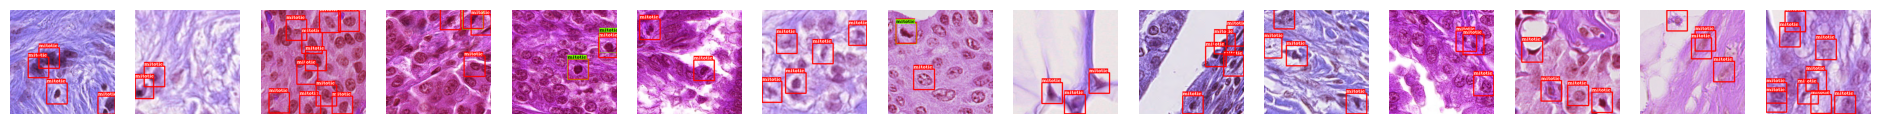

In [34]:
with torch.no_grad():
    img_count=0
    model.eval()
    for images, targets in (test_loader):
        images_infer = list(image.to(device) for image in images)
        outputs = model(images_infer)
        fig, ax = plt.subplots(1, 15, figsize=(24, 10))
        for i in range(len(images)):
            # image = images[i].permute(1,2,0).cpu().numpy().squeeze()
            image = images[i]
            boxes_gt = targets[i]['boxes'].data.cpu().numpy().tolist()
            class_ids_gt = targets[i]['labels'].data.cpu().numpy().tolist()
            mean = targets[i]['mean']
            std = targets[i]['std']
            boxes_pred = outputs[i]['boxes'].data.cpu().numpy().tolist()
            labels_pred = outputs[i]['labels'].data.cpu().numpy().tolist()
            scores_pred = outputs[i]['scores'].data.cpu().numpy().tolist()
            img_path = targets[i]['path']
            # print(scores_pred)
            # print(boxes_pred)
            # print("-----------------------------")
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            for bbox, category_id in zip(boxes_pred, labels_pred):
                class_name = category_id_to_name[category_id]
                img = visualize_bbox(img, bbox, class_name,(255, 0, 0), (255, 255, 255))

            for bbox, category_id in zip(boxes_gt, class_ids_gt):
                class_name = category_id_to_name[category_id]
                img = visualize_bbox(img, bbox, class_name,(124,252,0),(0,0,0), 1)
            
            ax[i].set_axis_off()
            ax[i].imshow(img)
            img_count+=1
        if img_count >10:
            break
            

# clssification model

In [47]:
# model = resnet18(weights=None)
cls_model = resnet34(weights=None)
cls_model.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))
cls_model.fc = nn.Sequential(
    nn.Flatten(),
    nn.Linear(512, 128),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(128, 1),
    nn.Sigmoid()
)
cls_model.load_state_dict(torch.load('MICCAI/models/ResNet34/Cls_0323-1.pth',map_location=torch.device(device)), )
cls_model = cls_model.to(device)
cls_model.eval()
train_transforms= transforms.Compose([
    transforms.ToTensor(),
])

## test batch of images

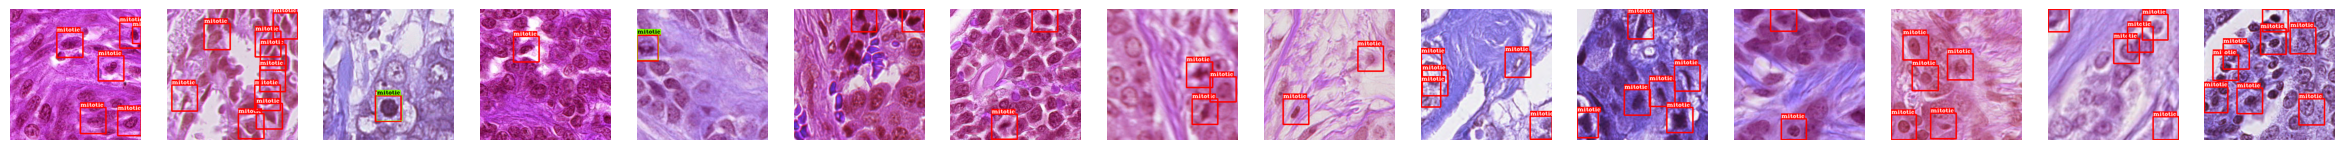

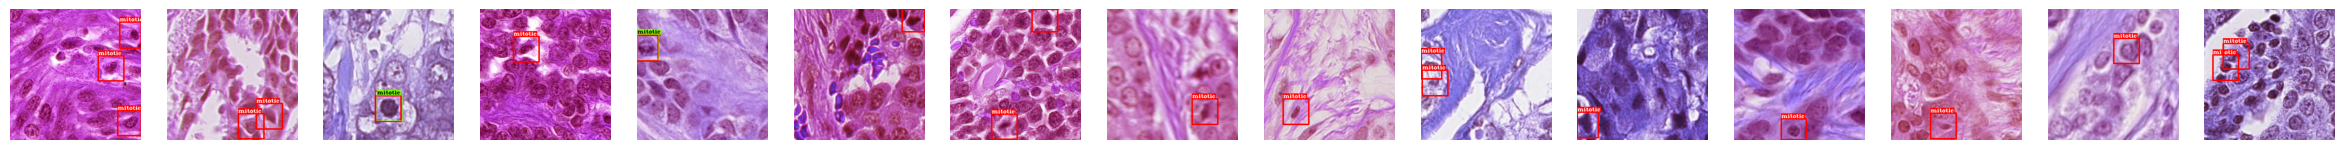

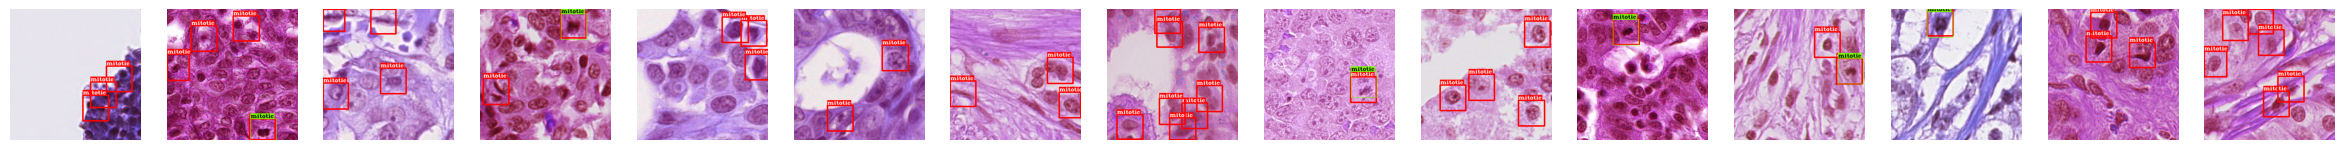

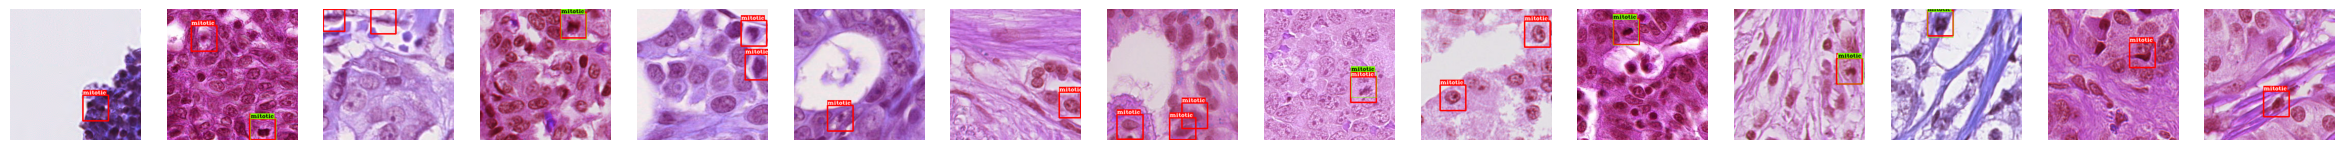

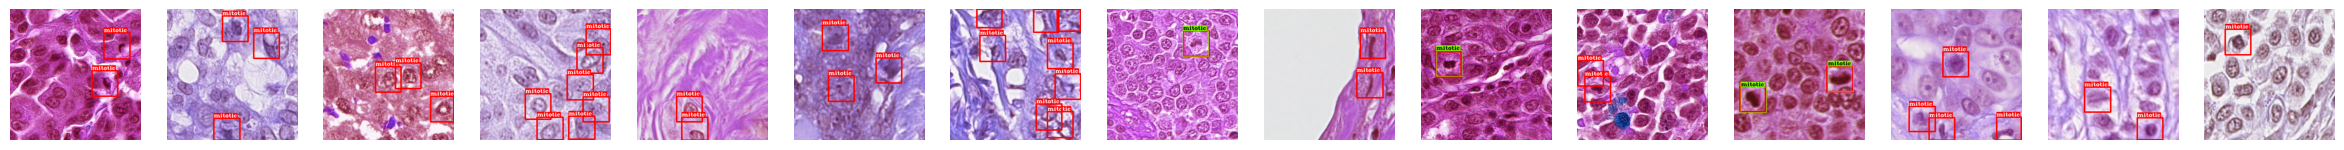

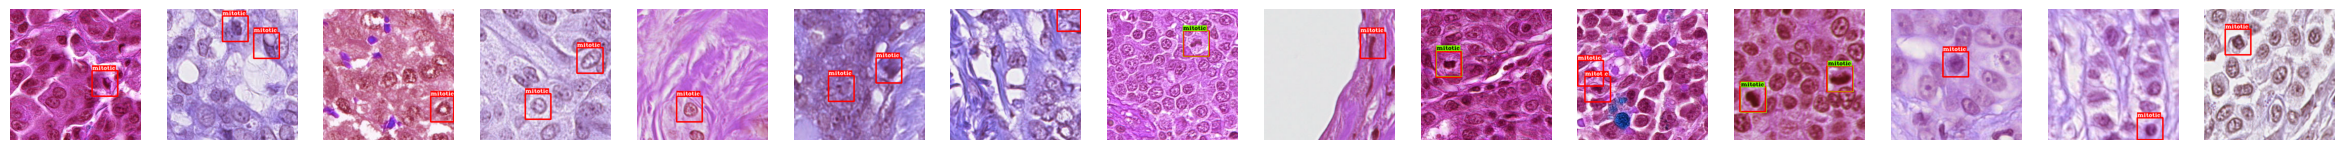

In [39]:
with torch.no_grad():
    count=0
    cls_model.eval()
    model.eval()  
    for images, targets in (test_loader):
        images_infer = list(image.to(device) for image in images)
        outputs = model(images_infer)
        fig, ax = plt.subplots(1, 15, figsize=(30, 15))
        for i in range(len(images)):
            image = images[i]
            boxes_gt = targets[i]['boxes'].data.cpu().numpy().tolist()
            class_ids_gt = targets[i]['labels'].data.cpu().numpy().tolist()
            mean = targets[i]['mean']
            std = targets[i]['std']
            img_path = targets[i]['path']
            boxes_pred = outputs[i]['boxes'].data.cpu().numpy().tolist()
            labels_pred = outputs[i]['labels'].data.cpu().numpy().tolist()
            scores_pred = outputs[i]['scores'].data.cpu().numpy().tolist()
            
            
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            for bbox, category_id in zip(boxes_pred, labels_pred):
                class_name = category_id_to_name[category_id]
                img = visualize_bbox(img, bbox, class_name,(255, 0, 0), (255, 255, 255))

            for bbox, category_id in zip(boxes_gt, class_ids_gt):
                class_name = category_id_to_name[category_id]
                img = visualize_bbox(img, bbox, class_name,(124,252,0),(0,0,0), 1)
            
            ax[i].set_axis_off()
            ax[i].imshow(img)
        fig, ax = plt.subplots(1, 15, figsize=(30, 15))
        for i in range(len(images)):
            image = images[i]
            boxes_gt = targets[i]['boxes'].data.cpu().numpy().tolist()
            class_ids_gt = targets[i]['labels'].data.cpu().numpy().tolist()
            mean = targets[i]['mean']
            std = targets[i]['std']
            img_path = targets[i]['path']
            # print(img_path)
            boxes_pred = outputs[i]['boxes'].data.cpu().numpy().tolist()
            labels_pred = outputs[i]['labels'].data.cpu().numpy().tolist()
            scores_pred = outputs[i]['scores'].data.cpu().numpy().tolist()
            # print(scores_pred)
        
            if len(boxes_pred)>0:
                boxes_after_cls = []
                labels_after_cls = []
                
                for j in range(len(boxes_pred)):
                    box = boxes_pred[j]
                    if scores_pred[j] < 0.5:
                        ori_img = cv2.imread(img_path)
                        ori_img = cv2.cvtColor(ori_img, cv2.COLOR_BGR2RGB)
                        box = list(int(b) for b in box)
                        img_cutted = ori_img[box[1]:box[3], box[0]:box[2]]
                        # img_cutted = cv2.cvtColor(img_cutted, cv2.COLOR_BGR2RGB)
                        img_cutted  = cv2.resize(img_cutted , (50,50))
                        img_cutted = np.array(img_cutted, dtype=np.uint8)
                        img_cutted= train_transforms(img_cutted)
                        mean, std = img_cutted.mean([1,2]), img_cutted.std([1,2])
                        img_cutted = fn.normalize(img_cutted, mean=mean, std=std)
                        img_cutted = img_cutted.float().to(device)
                        cls_output = cls_model(img_cutted.unsqueeze(0))
                        # print(cls_output)
                        # print(box)
                        if cls_output.item()>0.5:
                            boxes_after_cls.append(box)
                            labels_after_cls.append(labels_pred[j])
                    else:
                        boxes_after_cls.append(box)
                        labels_after_cls.append(labels_pred[j])
            
                boxes_pred = boxes_after_cls
                labels_pred = labels_after_cls
                
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            for bbox, category_id in zip(boxes_pred, labels_pred):
                class_name = category_id_to_name[category_id]
                img = visualize_bbox(img, bbox, class_name,(255, 0, 0), (255, 255, 255))

            for bbox, category_id in zip(boxes_gt, class_ids_gt):
                class_name = category_id_to_name[category_id]
                img = visualize_bbox(img, bbox, class_name,(124,252,0),(0,0,0), 1)
            
            ax[i].set_axis_off()
            ax[i].imshow(img)
        count+=1
        if count==3: break

        

## test single image

In [67]:
img_path = "MICCAI/cutted_images/test&valid/0366.png"
box = [85, 109, 135, 159]
plt.figure(figsize=(6, 6))
plt.axis('off')

with torch.no_grad():
    cls_model.eval()
    ori_img = cv2.imread(img_path)
    ori_img = cv2.cvtColor(ori_img, cv2.COLOR_BGR2RGB)
    box = list(int(b) for b in box)
    img_cutted = ori_img[box[1]:box[3], box[0]:box[2]]
    # cv2.imwrite("MICCAI/test/003.png", img_cutted)
    plt.imshow(img_cutted)
    # img_cutted = cv2.imread("MICCAI/test/001.png")
    img_cutted = cv2.resize(img_cutted, (50,50))
    img_cutted = np.array(img_cutted, dtype=np.uint8)
    img_cutted= train_transforms(img_cutted)
    mean, std = img_cutted.mean([1,2]), img_cutted.std([1,2])
    print(mean)
    print(std)
    img_cutted = fn.normalize(img_cutted, mean=mean, std=std)
    img_cutted = img_cutted.float().to(device)
    cls_output = cls_model(img_cutted.unsqueeze(0))
    print(cls_output)

tensor([0.4523, 0.3021, 0.5894])
tensor([0.1448, 0.1581, 0.2239])
tensor([[0.7603]], device='cuda:0')


In [58]:
plt.figure(figsize=(6, 6))
plt.axis('off')
ori_img = cv2.imread(img_path)
ori_img = cv2.cvtColor(ori_img, cv2.COLOR_BGR2RGB)
plt.imshow(ori_img)

## test second stage

In [53]:
cocoResult_2nd_stage(model, cls_model, test_loader, 0.4, 0.5)
valid_result_2nd = valid_2nd_stage(model, cls_model, test_loader, 0.4, 0.5)
print( f"mAP: {valid_result_2nd['mAP']}\nf1: {valid_result_2nd['f1']}\nmAR: {valid_result_2nd['mAR']}")

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.20s).
Accumulating evaluation results...
DONE (t=0.05s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.553
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.739
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.685
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.553
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.739
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.775
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | max

In [27]:
f1_list = []
mAP_list = []
mAR_list = []
for thred in tqdm(np.arange(0, 1.1, 0.1)):
    valid_result_2nd = valid_2nd_stage(model, cls_model, test_loader, thred, 0.5)
    f1_list.append(valid_result_2nd['f1'])
    mAP_list.append(valid_result_2nd['mAP'])
    mAR_list.append(valid_result_2nd['mAR'])

100%|███████████████████████████████████████████| 11/11 [15:23<00:00, 83.95s/it]


In [28]:
f1_list = np.array(f1_list)
mAP_list = np.array(mAP_list)
mAR_list = np.array(mAR_list)
thredshold = np.arange(0, 1.1, 0.1)
print(f1_list)
print(mAP_list)
print(mAR_list)

[0.64741132 0.64741132 0.64741132 0.64696227 0.64567146 0.64289043
 0.64080492 0.63551728 0.61816126 0.51115614 0.49192289]
[0.5537532  0.5537532  0.5537532  0.5537027  0.55343562 0.55272875
 0.55255603 0.55070954 0.5436161  0.48205235 0.46591982]
[0.7792 0.7792 0.7792 0.778  0.7748 0.7682 0.7626 0.7512 0.7164 0.544
 0.521 ]


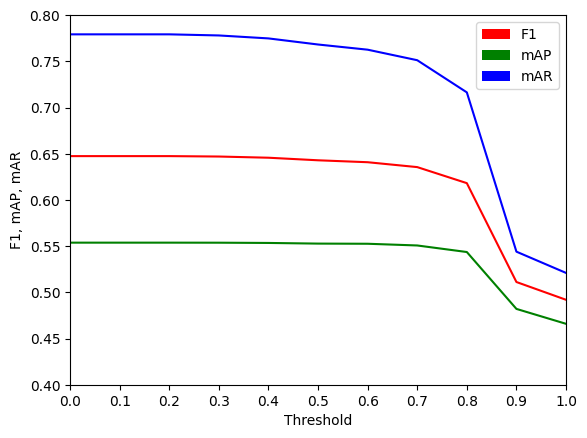

In [35]:
plt.plot(thredshold,f1_list,color='red')
plt.plot(thredshold,mAP_list,color="green")
plt.plot(thredshold,mAR_list,color="blue")
b1 = plt.Rectangle((0, 0), 1, 1, fc="red")
b2 = plt.Rectangle((0, 0), 1, 1, fc="green")
b3 = plt.Rectangle((0, 0), 1, 1, fc="blue")
plt.legend([b1, b2, b3], ['F1', 'mAP', 'mAR'])
plt.xticks(thredshold)
plt.xlim(0, 1.0)
plt.ylim(0.4, 0.8)
plt.xlabel("Threshold")
plt.ylabel("F1, mAP, mAR")
plt.show()

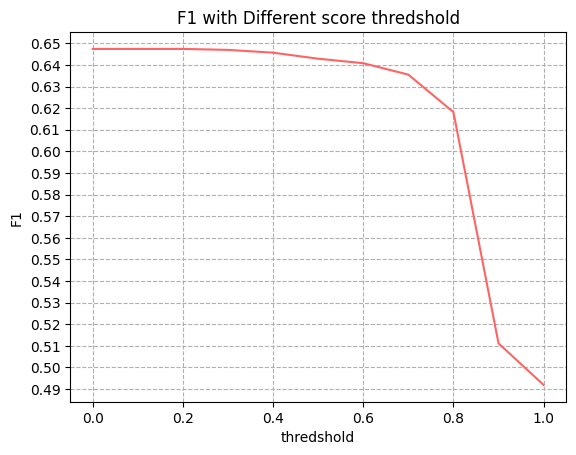

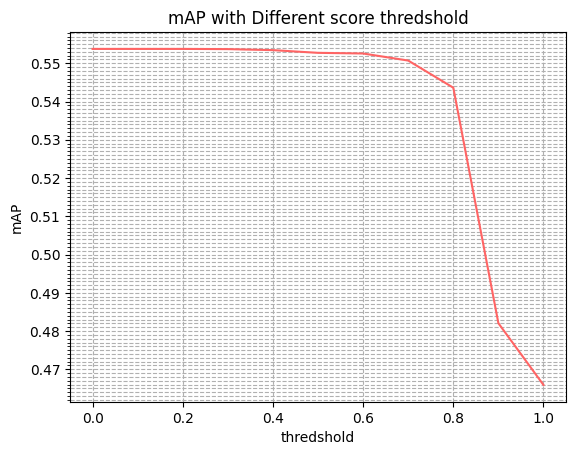

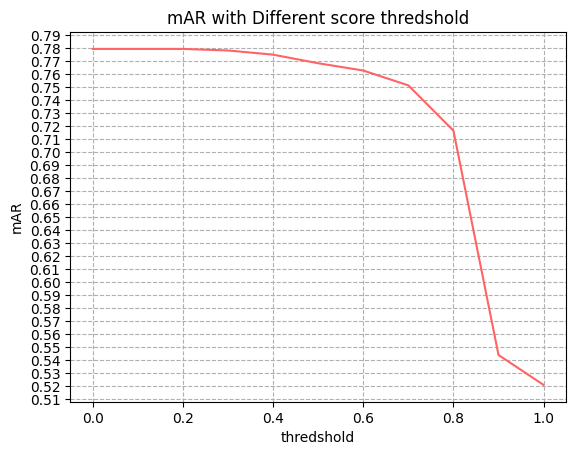

In [37]:
ax = plt.axes()
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.01))
# ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.001))
plt.grid(True, which='both', ls='dashed')
plt.plot(thredshold,f1_list,color=(255/255,100/255,100/255))
plt.title("F1 with Different score thredshold") # title
plt.ylabel("F1") # y label
plt.xlabel("thredshold") # x label
plt.show()

ax = plt.axes()
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.01))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.001))
plt.grid(True, which='both', ls='dashed')
plt.plot(thredshold,mAP_list,color=(255/255,100/255,100/255))
plt.title("mAP with Different score thredshold") # title
plt.ylabel("mAP") # y label
plt.xlabel("thredshold") # x label
plt.show()

ax = plt.axes()
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.01))
# ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.001))
plt.grid(True, which='both', ls='dashed')
plt.plot(thredshold,mAR_list,color=(255/255,100/255,100/255))
plt.title("mAR with Different score thredshold") # title
plt.ylabel("mAR") # y label
plt.xlabel("thredshold") # x label
plt.show()

## Ensemble test

In [41]:
valid_result_2nd = valid_2nd_stage_ensemble(model, cls_model, cls_model2, cls_model3, test_loader, 0.5, 0.5)
print( f"mAP: {valid_result_2nd['mAP']}\nf1: {valid_result_2nd['f1']}\nmAR: {valid_result_2nd['mAR']}\ndelete count; {valid_result_2nd['delete_count']}")

mAP: 0.5537840255291355
f1: 0.6468101978240383
mAR: 0.7774
delete count; 2044


In [44]:
valid_result_2nd = valid_2nd_stage_ensemble(model, cls_model, cls_model2, cls_model3, test_loader, 0.5, 0.5)
print( f"mAP: {valid_result_2nd['mAP']}\nf1: {valid_result_2nd['f1']}\nmAR: {valid_result_2nd['mAR']}\ndelete count; {valid_result_2nd['delete_count']}")

mAP: 0.5538402821636537
f1: 0.6469177914770673
mAR: 0.7775999999999998
delete count; 2035


In [45]:
cls_model2 = resnext101_64x4d(weights=None)
cls_model2.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))
cls_model2.fc = nn.Sequential(
    nn.Flatten(),
    nn.Linear(2048, 128),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(128, 1),
    nn.Sigmoid()
)
cls_model2.load_state_dict(torch.load('MICCAI/models/ResNext101/Cls_0325-2.pth',map_location=torch.device(device)), )
cls_model2.eval()
cls_model2 = cls_model2.to(device)

In [46]:
cls_model3 = resnet18(weights=None)
cls_model3.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))
cls_model3.fc = nn.Sequential(
    nn.Flatten(),
    nn.Linear(512, 128),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(128, 1),
    nn.Sigmoid()
)
cls_model3.load_state_dict(torch.load('MICCAI/models/ResNet18/Cls_0325-1.pth',map_location=torch.device(device)), )
cls_model3.eval()
cls_model3 = cls_model3.to(device)


In [ ]:
f1_list = []
mAP_list = []
mAR_list = []
for thred in tqdm(np.arange(0, 1.1, 0.1)):
    valid_result_2nd = valid_2nd_stage_ensemble(model, cls_model, cls_model2, cls_model3, test_loader, thred, 0.5)
    f1_list.append(valid_result_2nd['f1'])
    mAP_list.append(valid_result_2nd['mAP'])
    mAR_list.append(valid_result_2nd['mAR'])
    
f1_list = np.array(f1_list)
mAP_list = np.array(mAP_list)
mAR_list = np.array(mAR_list)
thredshold = np.arange(0, 1.1, 0.1)   
    


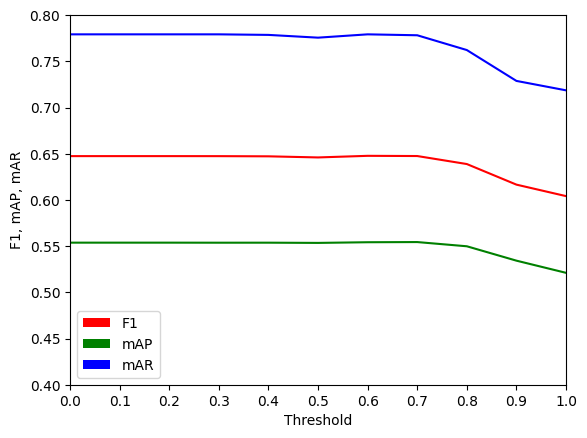

In [44]:
plt.plot(thredshold,f1_list,color='red')
plt.plot(thredshold,mAP_list,color="green")
plt.plot(thredshold,mAR_list,color="blue")
b1 = plt.Rectangle((0, 0), 1, 1, fc="red")
b2 = plt.Rectangle((0, 0), 1, 1, fc="green")
b3 = plt.Rectangle((0, 0), 1, 1, fc="blue")
plt.legend([b1, b2, b3], ['F1', 'mAP', 'mAR'])
plt.xticks(thredshold)
plt.xlim(0, 1.0)
plt.ylim(0.4, 0.8)
plt.xlabel("Threshold")
plt.ylabel("F1, mAP, mAR")
plt.show()

In [40]:
print(f1_list)
print(mAP_list)
print(mAR_list)

[0.64741132 0.64741132 0.64741132 0.6473744  0.64718321 0.64598439
 0.64772082 0.64750113 0.63883042 0.61655217 0.60411538]
[0.5537532  0.5537532  0.5537532  0.55369918 0.55372258 0.55348746
 0.55420621 0.55439102 0.54983431 0.53426595 0.52109629]
[0.7792 0.7792 0.7792 0.7792 0.7786 0.7756 0.7792 0.7782 0.7622 0.7288
 0.7186]


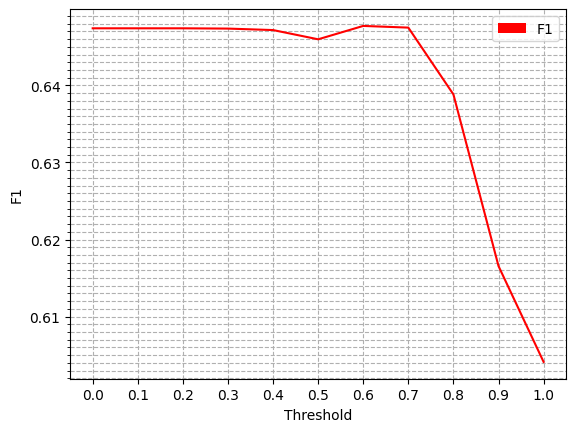

In [55]:
import matplotlib.ticker as ticker
ax = plt.axes()
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.01))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.001))
plt.grid(True, which='both', ls='dashed')
plt.plot(thredshold,f1_list,color='red')
b1 = plt.Rectangle((0, 0), 1, 1, fc="red")
plt.legend([b1], ['F1'])
plt.xticks(thredshold)
plt.xlabel("Threshold")
plt.ylabel("F1")
plt.show()

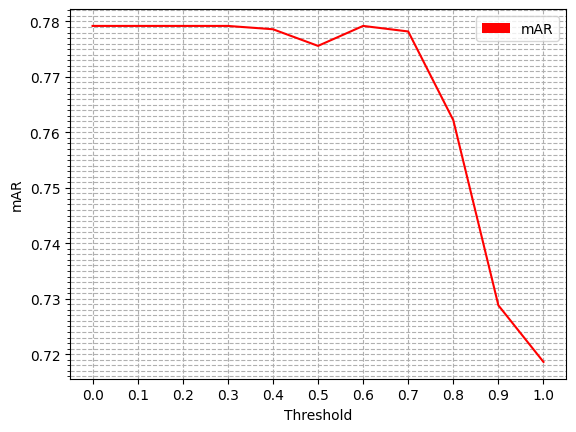

In [58]:
import matplotlib.ticker as ticker
ax = plt.axes()
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.01))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.001))
plt.grid(True, which='both', ls='dashed')
plt.plot(thredshold,mAR_list,color='red')
b1 = plt.Rectangle((0, 0), 1, 1, fc="red")
plt.legend([b1], ['mAR'])
plt.xticks(thredshold)
plt.xlabel("Threshold")
plt.ylabel("mAR")
plt.show()

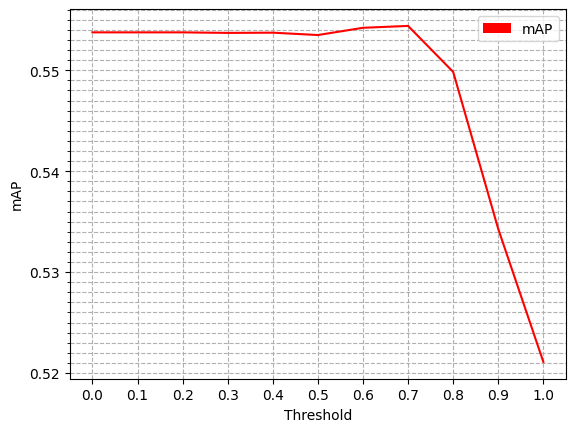

In [59]:
import matplotlib.ticker as ticker
ax = plt.axes()
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.01))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.001))
plt.grid(True, which='both', ls='dashed')
plt.plot(thredshold,mAP_list,color='red')
b1 = plt.Rectangle((0, 0), 1, 1, fc="red")
plt.legend([b1], ['mAP'])
plt.xticks(thredshold)
plt.xlabel("Threshold")
plt.ylabel("mAP")
plt.show()

In [64]:
with torch.no_grad():
    images, targets = next(iter(test_loader))
    img_count=1
    images_infer = list(image.to(device) for image in images)
    model.eval()
    outputs = model(images_infer)

[127.21956634521484, 80.177978515625, 177.3924560546875, 129.90565490722656]
[211.7903289794922, 0.0, 256.0, 44.20024490356445]
[0.0, 89.58660125732422, 44.83588409423828, 139.7997283935547]
[112.01811218261719, 0.0, 161.55447387695312, 41.25556182861328]
[110.98194885253906, 132.3033905029297, 160.9442596435547, 182.10281372070312]
[62.07598876953125, 0.0, 112.06507873535156, 43.80137634277344]
[48.593299865722656, 137.7870635986328, 98.58032989501953, 187.5379180908203]
[131.12098693847656, 0.15391235053539276, 181.3495635986328, 43.50592803955078]
[165.95640563964844, 38.37374496459961, 216.16107177734375, 88.42491149902344]
[127.86573791503906, 38.09576416015625, 178.2882843017578, 88.10231018066406]
[40.42148208618164, 115.50932312011719, 90.73247528076172, 165.37057495117188]
[0.0, 28.91149139404297, 23.688135147094727, 74.52497863769531]
[180.84927368164062, 82.86476135253906, 230.5127716064453, 132.38919067382812]
[23.49924659729004, 149.71788024902344, 73.7483901977539, 199.75

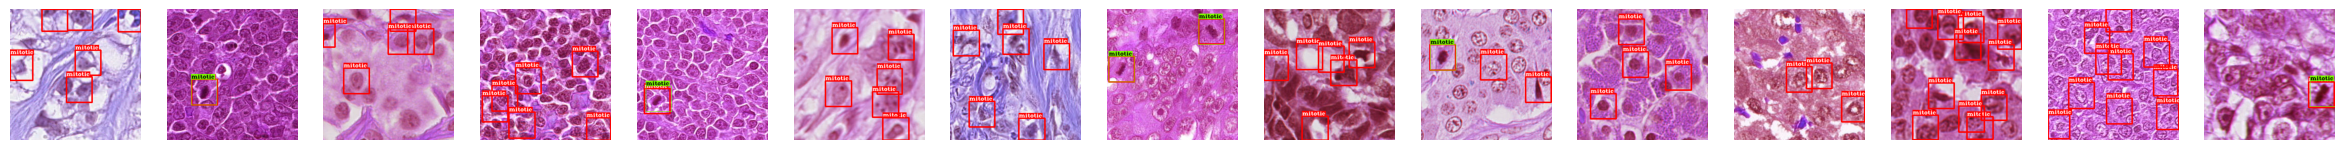

In [65]:
with torch.no_grad():
    delete_count=0
    COCODt = dict()
    COCODt['images']=list()
    COCODt['annotations'] = list()
    COCODt['categories'] = data['categories']
    annotDt_count=1

    COCOgt = dict()
    COCOgt['images']=list()
    COCOgt['annotations'] = list()
    COCOgt['categories'] = data['categories']
    annotGt_count=1
    fig, ax = plt.subplots(1, 15, figsize=(30, 15))
    for i in range(len(images)):
        image = images[i]
        boxes_gt = targets[i]['boxes'].data.cpu().numpy().tolist()
        class_ids_gt = targets[i]['labels'].data.cpu().numpy().tolist()
        mean = targets[i]['mean']
        std = targets[i]['std']
        img_path = targets[i]['path']
        boxes_pred = outputs[i]['boxes'].data.cpu().numpy().tolist()
        labels_pred = outputs[i]['labels'].data.cpu().numpy().tolist()
        scores_pred = outputs[i]['scores'].data.cpu().numpy().tolist()


        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        for bbox, category_id in zip(boxes_pred, labels_pred):
            print(bbox)
            class_name = category_id_to_name[category_id]
            img = visualize_bbox(img, bbox, class_name,(255, 0, 0), (255, 255, 255))

        for bbox, category_id in zip(boxes_gt, class_ids_gt):
            class_name = category_id_to_name[category_id]
            img = visualize_bbox(img, bbox, class_name,(124,252,0),(0,0,0), 1)

        ax[i].set_axis_off()
        ax[i].imshow(img)
    ###################################################################### 

        for i in range(len(boxes_pred)):
            box = pascal2coco(boxes_pred[i])
            each_annot = {
                'bbox':box,
                'category_id':labels_pred[i],
                'image_id': img_count,
                'id': annotDt_count,
                'score': scores_pred[i],
                'iscrowd': 0,
                'area': box[2]*box[3],

            }
            COCODt['annotations'].append(each_annot)
            annotDt_count+=1

        for i in range(len(boxes_gt)):
            box = pascal2coco(boxes_gt[i])
            each_annot = {
                'bbox':box,
                'category_id':class_ids_gt[i],
                'image_id': img_count,
                'id': annotGt_count,
                'iscrowd': 0,
                'area': box[2]*box[3],
            }
            COCOgt['annotations'].append(each_annot)
            annotGt_count+=1

        each_image = {
                    'id': img_count,
                    'width': Img_size_training,
                    'height': Img_size_training,
                }
        COCOgt['images'].append(each_image)
        COCODt['images'].append(each_image)
        img_count+=1



    with open("MICCAI/cutted_labels/COCOgt.json", "w") as outfile:
        json.dump(COCOgt, outfile)
        outfile.close()

    with open("MICCAI/cutted_labels/COCOdt.json", "w") as outfile:
        json.dump(COCODt, outfile)
        outfile.close()

    with HiddenPrints():
        cocoGt=coco.COCO('MICCAI/cutted_labels/COCOgt.json')
        cocoDt=coco.COCO('MICCAI/cutted_labels/COCOdt.json')
        imgIds=sorted(cocoGt.getImgIds())
        imgIds=imgIds[0:img_count-1]
        imgId = imgIds[np.random.randint(img_count-1)]
        annType = ['segm','bbox','keypoints']
        annType = annType[1]
        cocoEval = COCOeval(cocoGt,cocoDt,annType)
        cocoEval.params.imgIds  = imgIds
        cocoEval.evaluate()
        cocoEval.accumulate()
        Precision = my_summarize(cocoEvalObj=cocoEval,ap=1)#mAp 0.5:0.95
        Recall = my_summarize(cocoEvalObj=cocoEval,ap=0) #recall
        f1 = (2*(Precision*Recall))/(Precision+Recall)

    print(f"mAP:{Precision}, f1:{f1}, mAR: {Recall}, delete_count: {delete_count}")


[127.21956634521484, 80.177978515625, 177.3924560546875, 129.90565490722656]
[211.7903289794922, 0.0, 256.0, 44.20024490356445]
[48.593299865722656, 137.7870635986328, 98.58032989501953, 187.5379180908203]
[131.12098693847656, 0.15391235053539276, 181.3495635986328, 43.50592803955078]
[165.95640563964844, 38.37374496459961, 216.16107177734375, 88.42491149902344]
[180.84927368164062, 82.86476135253906, 230.5127716064453, 132.38919067382812]
[14.978830337524414, 155.09365844726562, 64.49015045166016, 204.6498565673828]
[74.14942932128906, 36.965576171875, 124.1927490234375, 87.23152923583984]
[93.71027374267578, 0.0, 143.56491088867188, 49.29787063598633]
[3.613115072250366, 92.83782196044922, 53.135746002197266, 142.5401153564453]
[179.12359619140625, 19.251737594604492, 229.3225860595703, 68.90660858154297]
[166.0455780029297, 64.8828125, 216.08767700195312, 114.95548248291016]
[17.233102798461914, 69.91384887695312, 67.13595581054688, 119.7000732421875]
[89.13426208496094, 83.42301940

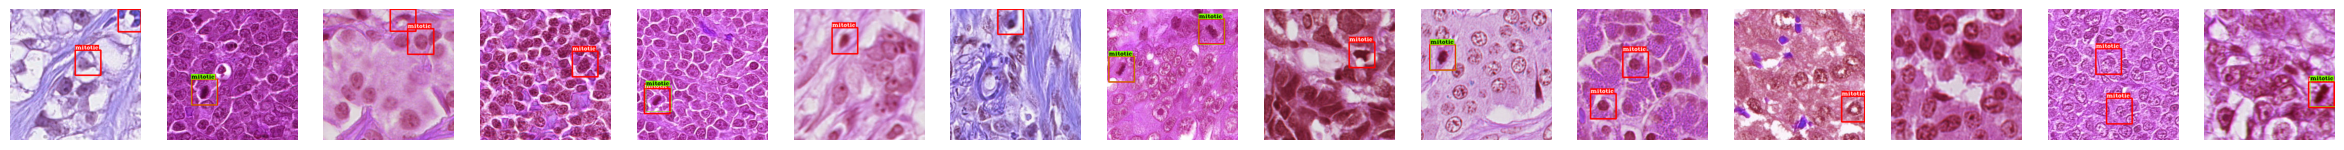

In [66]:
with torch.no_grad():
    COCODt = dict()
    COCODt['images']=list()
    COCODt['annotations'] = list()
    COCODt['categories'] = data['categories']
    annotDt_count=1

    COCOgt = dict()
    COCOgt['images']=list()
    COCOgt['annotations'] = list()
    COCOgt['categories'] = data['categories']
    annotGt_count=1
    img_count=1
    delete_count=0
    fig, ax = plt.subplots(1, 15, figsize=(30, 15))
    for i in range(len(images)):
        img = images[i].permute(1,2,0).cpu().numpy().squeeze()
        boxes_gt = targets[i]['boxes'].data.cpu().numpy().tolist()
        class_ids_gt = targets[i]['labels'].data.cpu().numpy().tolist()
        boxes_pred = outputs[i]['boxes'].data.cpu().numpy().tolist()
        labels_pred = outputs[i]['labels'].data.cpu().numpy().tolist()
        scores_pred = outputs[i]['scores'].data.cpu().numpy().tolist()
        img_path = targets[i]['path']

        #clssify bbox second time
        ##################################################################
        if len(boxes_pred)>0:
            img = cv2.imread(img_path)
            boxes_after_cls = []
            labels_after_cls = []
            scores_after_cls = []

            for j in range(len(boxes_pred)):
                box = copy.deepcopy(boxes_pred[j])
                if scores_pred[j] < 0.5:
                    box = list(int(b) for b in box)
                    img_cutted = img[box[1]:box[3], box[0]:box[2]]
                    img_cutted = cv2.cvtColor(img_cutted, cv2.COLOR_BGR2RGB)
                    img_cutted  = cv2.resize(img_cutted , (50,50))
                    img_cutted = np.array(img_cutted, dtype=np.uint8)
                    img_cutted= train_transforms(img_cutted)
                    mean, std = img_cutted.mean([1,2]), img_cutted.std([1,2])
                    img_cutted = fn.normalize(img_cutted, mean=mean, std=std)
                    img_cutted = img_cutted.float().to(device)
                    cls_output = cls_model(img_cutted.unsqueeze(0))
                    cls_output2 = cls_model2(img_cutted.unsqueeze(0))
                    cls_output3 = cls_model3(img_cutted.unsqueeze(0))
                    all_result = np.array([cls_output.item(), cls_output2.item(), cls_output3.item()])
                    mask = all_result > 0.5
                    poll_result = mask.sum()
                    if poll_result >= 2:
                        boxes_after_cls.append(boxes_pred[j])
                        labels_after_cls.append(labels_pred[j])
                        scores_after_cls.append(scores_pred[j])
                    else:
                        delete_count+=1
                else:
                    boxes_after_cls.append(boxes_pred[j])
                    labels_after_cls.append(labels_pred[j])
                    scores_after_cls.append(scores_pred[j])

            boxes_pred = boxes_after_cls
            labels_pred = labels_after_cls
            scores_pred = scores_after_cls
        
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        for bbox, category_id in zip(boxes_pred, labels_pred):
            print(bbox)
            class_name = category_id_to_name[category_id]
            img = visualize_bbox(img, bbox, class_name,(255, 0, 0), (255, 255, 255))

        for bbox, category_id in zip(boxes_gt, class_ids_gt):
            class_name = category_id_to_name[category_id]
            img = visualize_bbox(img, bbox, class_name,(124,252,0),(0,0,0), 1)

        ax[i].set_axis_off()
        ax[i].imshow(img)
        ###################################################################### 

        for i in range(len(boxes_pred)):
            box = pascal2coco(boxes_pred[i])
            each_annot = {
                'bbox':box,
                'category_id':labels_pred[i],
                'image_id': img_count,
                'id': annotDt_count,
                'score': scores_pred[i],
                'iscrowd': 0,
                'area': box[2]*box[3],

            }
            COCODt['annotations'].append(each_annot)
            annotDt_count+=1

        for i in range(len(boxes_gt)):
            box = pascal2coco(boxes_gt[i])
            each_annot = {
                'bbox':box,
                'category_id':class_ids_gt[i],
                'image_id': img_count,
                'id': annotGt_count,
                'iscrowd': 0,
                'area': box[2]*box[3],
            }
            COCOgt['annotations'].append(each_annot)
            annotGt_count+=1
            
        each_image = {
                    'id': img_count,
                    'width': Img_size_training,
                    'height': Img_size_training,
                }
        COCOgt['images'].append(each_image)
        COCODt['images'].append(each_image)
        img_count+=1



    with open("MICCAI/cutted_labels/COCOgt.json", "w") as outfile:
        json.dump(COCOgt, outfile)
        outfile.close()

    with open("MICCAI/cutted_labels/COCOdt.json", "w") as outfile:
        json.dump(COCODt, outfile)
        outfile.close()

    with HiddenPrints():
        cocoGt=coco.COCO('MICCAI/cutted_labels/COCOgt.json')
        cocoDt=coco.COCO('MICCAI/cutted_labels/COCOdt.json')
        imgIds=sorted(cocoGt.getImgIds())
        imgIds=imgIds[0:img_count-1]
        imgId = imgIds[np.random.randint(img_count-1)]
        annType = ['segm','bbox','keypoints']
        annType = annType[1]
        cocoEval = COCOeval(cocoGt,cocoDt,annType)
        cocoEval.params.imgIds  = imgIds
        cocoEval.evaluate()
        cocoEval.accumulate()
        Precision = my_summarize(cocoEvalObj=cocoEval,ap=1)#mAp 0.5:0.95
        Recall = my_summarize(cocoEvalObj=cocoEval,ap=0) #recall
        f1 = (2*(Precision*Recall))/(Precision+Recall)

    print(f"mAP:{Precision}, f1:{f1}, mAR: {Recall}, delete_count: {delete_count}")

## full image test